# 1. Setup and Import Libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 2. Download 25+ Years of Data for SPY, QQQ, DIA

In [26]:
tickers = ['SPY', 'QQQ', 'DIA', '^VIX']
start_date = "2000-01-01"
end_date = "2025-05-31"

data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Check data

In [27]:
for ticker in data:
    print(f"=== {ticker} - First 5 rows ===")
    display(data[ticker].head())
    
    print(f"=== {ticker} - Last 5 rows ===")
    display(data[ticker].tail())

=== SPY - First 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2000-01-03,92.414963,94.202102,91.422108,94.202102,8164300
2000-01-04,88.800964,91.541245,88.731464,91.203674,8089800
2000-01-05,88.959763,89.932760,87.212339,88.920048,12177900
2000-01-06,87.530128,89.912981,87.530128,88.721555,6227200
2000-01-07,92.613503,92.613503,88.999511,89.158368,8066500


=== SPY - Last 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2025-05-23,579.109985,581.809998,575.599976,575.979980,76029000
2025-05-27,591.150024,591.309998,578.429993,586.070007,72588500
2025-05-28,587.729980,592.770020,586.989990,591.559998,68445500
2025-05-29,590.049988,593.200012,586.070007,593.059998,69973300
2025-05-30,589.390015,591.130005,583.239990,588.929993,90601200


=== QQQ - First 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ
Date,,,,,
2000-01-03,80.314293,81.532782,76.923716,81.532782,36345200
2000-01-04,74.804604,79.254736,74.539715,77.983269,33786600
2000-01-05,72.897453,75.970166,71.414075,74.168921,42496600
2000-01-06,67.891037,74.592727,67.599659,73.639127,37134800
2000-01-07,76.287979,76.287979,69.930648,70.301492,28138200


=== QQQ - Last 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ
Date,,,,,
2025-05-23,509.239990,511.839996,505.579987,506.179993,58368100
2025-05-27,521.219971,521.710022,514.590027,516.150024,47226300
2025-05-28,518.909973,523.679993,518.390015,522.179993,46637200
2025-05-29,519.929993,526.479980,517.320007,526.330017,58513300
2025-05-30,519.109985,520.679993,511.929993,519.440002,67662800


=== DIA - First 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,DIA,DIA,DIA,DIA,DIA
Date,,,,,
2000-01-03,65.827843,67.295920,65.537852,67.295920,1278800
2000-01-04,63.661942,65.519692,63.661942,65.120955,1535700
2000-01-05,64.486671,65.175399,63.236087,63.797944,2007000
2000-01-06,64.812851,65.637511,64.486612,64.613483,2639500
2000-01-07,66.987778,67.024027,65.664697,65.719070,3767400


=== DIA - Last 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,DIA,DIA,DIA,DIA,DIA
Date,,,,,
2025-05-23,416.329987,418.170013,413.829987,413.940002,3117800
2025-05-27,423.850006,423.859985,419.190002,420.700012,3126600
2025-05-28,421.420013,424.829987,420.739990,423.730011,1790900
2025-05-29,422.459991,423.019989,418.579987,422.459991,2751400
2025-05-30,422.850006,424.269989,419.510010,422.160004,2957500


=== ^VIX - First 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
2000-01-03,24.209999,26.150000,23.980000,24.360001,0
2000-01-04,27.010000,27.180000,24.799999,24.940001,0
2000-01-05,26.410000,29.000000,25.850000,27.980000,0
2000-01-06,25.730000,26.709999,24.700001,26.680000,0
2000-01-07,21.719999,25.170000,21.719999,25.139999,0


=== ^VIX - Last 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
2025-05-23,22.290001,25.530001,19.830000,20.139999,0
2025-05-27,18.959999,21.010000,18.950001,20.629999,0
2025-05-28,19.309999,19.430000,18.680000,19.209999,0
2025-05-29,19.180000,20.200001,18.110001,18.250000,0
2025-05-30,18.570000,20.549999,18.570000,19.610001,0


# 3. Calculate Technical Indicators (RSI, MACD, TSI, etc.)

In [28]:
import ta

def add_indicators(df):
    df = df.copy()

    close = df['Close'].squeeze()

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=close, window=14).rsi()

    # MACD components
    macd = ta.trend.MACD(close=close)
    df['MACD_Line'] = macd.macd()
    df['Signal_Line'] = macd.macd_signal()
    df['MACD_Histogram'] = macd.macd_diff()

    # EMAs for reference
    df['EMA_3'] = ta.trend.EMAIndicator(close=close, window=3).ema_indicator()
    df['EMA_5'] = ta.trend.EMAIndicator(close=close, window=5).ema_indicator()

    return df

Add custom indicator TSI (Trend Strength Index) from TradingView

In [29]:
def trend_strength_index(close_prices, window=14):
    tsi_values = []
    close_array = close_prices.squeeze().astype(float).values  # Ensure 1D array

    for i in range(len(close_array)):
        if i + 1 < window:
            tsi_values.append(np.nan)
        else:
            price_window = close_array[i + 1 - window: i + 1]  # include index i
            index_window = np.arange(window)
            r, _ = pearsonr(index_window, price_window)
            tsi_values.append(r)

    return pd.Series(tsi_values, index=close_prices.index)

Apply TSI to each dataset (SPY, QQQ, DIA)

In [30]:
for ticker in ['SPY', 'QQQ', 'DIA']:
    df = data[ticker]
    df = add_indicators(df)
    df['TSI'] = trend_strength_index(df['Close'], window=14)
    data[ticker] = df

Add VIX values to each dataset (SPY, QQQ, DIA)

In [31]:
# Ensure VIX is aligned by date and rename the close column for clarity
vix_data = data['^VIX'][['Close']].rename(columns={'Close': 'VIX'})

for ticker in ['SPY', 'QQQ', 'DIA']:
    df = data[ticker]

    # Merge VIX values using the index (which should be the date)
    df = df.merge(vix_data, left_index=True, right_index=True, how='left')

    # Store the updated DataFrame back into your dictionary
    data[ticker] = df

Add Next Day's Return Column

In [32]:
for ticker in ['SPY', 'QQQ', 'DIA']:
    
    df = data[ticker]
    df['Return'] = (df['Close'].shift(-1) - df['Close']) / df['Close']
    df.dropna(inplace=True)
    data[ticker] = df

In [33]:
for ticker in data:
    print(f"=== {ticker} - First 5 rows ===")
    display(data[ticker].head())
    
    print(f"=== {ticker} - Last 5 rows ===")
    display(data[ticker].tail())

=== SPY - First 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,SPY,SPY,SPY,SPY,SPY,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2000-02-18,85.981209,88.244917,85.544353,88.244917,9409200,36.234452,-0.892218,-0.585329,-0.306889,87.157029,87.753210,-0.723618,26.000000,-0.002540
2000-02-22,85.762787,86.636499,84.849361,85.901787,16415400,35.654848,-1.063750,-0.681013,-0.382737,86.459908,87.089735,-0.837682,25.860001,0.011808
2000-02-23,86.775513,87.351369,85.464944,86.179800,12119000,40.414051,-1.105232,-0.765857,-0.339376,86.617710,86.984994,-0.904489,23.889999,-0.020137
2000-02-24,85.028091,87.073372,84.571378,86.854944,17375000,35.530753,-1.264533,-0.865592,-0.398941,85.822901,86.332693,-0.919246,24.379999,-0.003620
2000-02-25,84.720261,86.874755,84.591190,85.901757,10559900,34.734518,-1.399486,-0.972371,-0.427115,85.271581,85.795216,-0.935399,25.200001,0.020978


=== SPY - Last 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,SPY,SPY,SPY,SPY,SPY,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2025-05-22,583.090027,586.619995,581.409973,582.659973,70860400,59.499778,10.879004,9.581684,1.297320,585.461492,586.369279,0.808336,20.280001,-0.006826
2025-05-23,579.109985,581.809998,575.599976,575.979980,76029000,56.292174,9.910020,9.647351,0.262669,582.285739,583.949514,0.686693,22.290001,0.020791
2025-05-27,591.150024,591.309998,578.429993,586.070007,72588500,62.821677,9.998368,9.717554,0.280814,586.717881,586.349684,0.620869,18.959999,-0.005785
2025-05-28,587.729980,592.770020,586.989990,591.559998,68445500,60.076236,9.680822,9.710208,-0.029386,587.223931,586.809783,0.491271,19.309999,0.003947
2025-05-29,590.049988,593.200012,586.070007,593.059998,69973300,61.311410,9.506781,9.669523,-0.162742,588.636959,587.889851,0.342391,19.180000,-0.001119


=== QQQ - First 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2000-02-18,83.440002,87.307380,83.440002,86.989514,25271200,53.291615,1.841868,1.762700,0.079168,84.580162,84.718755,0.692835,26.000000,0.003175
2000-02-22,83.704895,84.711473,81.585784,83.916806,37226200,53.801627,1.698855,1.749931,-0.051076,84.142529,84.380802,0.509478,25.860001,0.055696
2000-02-23,88.366905,89.002638,84.049218,84.492906,32170800,61.723172,1.939346,1.787814,0.151532,86.254717,85.709503,0.477302,23.889999,0.021583
2000-02-24,90.274101,90.532368,86.459703,88.896680,48868200,64.411600,2.257805,1.881812,0.375993,88.264409,87.231036,0.524099,24.379999,-0.022887
2000-02-25,88.208008,91.121786,88.049074,90.009252,32617600,59.533370,2.316763,1.968802,0.347961,88.236208,87.556693,0.504661,25.200001,-0.000600


=== QQQ - Last 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2025-05-22,514.000000,517.710022,512.299988,513.659973,55607200,64.287173,13.604804,11.898940,1.705864,515.338819,515.575589,0.844457,20.280001,-0.009261
2025-05-23,509.239990,511.839996,505.579987,506.179993,58368100,60.139417,12.657579,12.050668,0.606911,512.289404,513.463723,0.750104,22.290001,0.023525
2025-05-27,521.219971,521.710022,514.590027,516.150024,47226300,66.072422,12.726872,12.185909,0.540964,516.754688,516.049139,0.696755,18.959999,-0.004432
2025-05-28,518.909973,523.679993,518.390015,522.179993,46637200,64.091481,12.451854,12.239098,0.212756,517.832330,517.002750,0.601718,19.309999,0.001966
2025-05-29,519.929993,526.479980,517.320007,526.330017,58513300,64.596238,12.175851,12.226448,-0.050598,518.881162,517.978498,0.479277,19.180000,-0.001577


=== DIA - First 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,DIA,DIA,DIA,DIA,DIA,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2000-02-18,59.415348,61.013316,59.270078,61.013316,1526700,30.332218,-1.251056,-1.014634,-0.236422,60.320093,60.775210,-0.904347,26.000000,0.005501
2000-02-22,59.742191,60.123524,58.688986,59.778509,1518800,32.677462,-1.321867,-1.076081,-0.245787,60.031142,60.430871,-0.914346,25.860001,-0.005471
2000-02-23,59.415348,60.141697,59.052174,59.832999,1558900,31.534259,-1.388356,-1.138536,-0.249820,59.723245,60.092363,-0.926348,23.889999,-0.002445
2000-02-24,59.270058,59.669549,57.853678,59.596915,4518700,31.014830,-1.436216,-1.198072,-0.238144,59.496651,59.818261,-0.922107,24.379999,-0.033701
2000-02-25,57.272625,58.961387,57.054720,58.452942,3316900,24.934082,-1.616685,-1.281794,-0.334891,58.384638,58.969716,-0.913471,25.200001,0.016011


=== DIA - Last 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,DIA,DIA,DIA,DIA,DIA,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2025-05-22,418.820007,421.149994,417.369995,417.869995,2638600,54.260049,4.640880,3.894686,0.746195,420.723628,421.575427,0.730394,20.280001,-0.005945
2025-05-23,416.329987,418.170013,413.829987,413.940002,3117800,51.650940,4.050888,3.925926,0.124962,418.526807,419.826947,0.562244,22.290001,0.018063
2025-05-27,423.850006,423.859985,419.190002,420.700012,3126600,58.189709,4.142367,3.969214,0.173153,421.188407,421.167967,0.464270,18.959999,-0.005733
2025-05-28,421.420013,424.829987,420.739990,423.730011,1790900,55.574225,3.972986,3.969969,0.003018,421.304210,421.251982,0.289062,19.309999,0.002468
2025-05-29,422.459991,423.019989,418.579987,422.459991,2751400,56.475879,3.877966,3.951568,-0.073602,421.882101,421.654652,0.122473,19.180000,0.000923


=== ^VIX - First 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
2000-01-03,24.209999,26.150000,23.980000,24.360001,0
2000-01-04,27.010000,27.180000,24.799999,24.940001,0
2000-01-05,26.410000,29.000000,25.850000,27.980000,0
2000-01-06,25.730000,26.709999,24.700001,26.680000,0
2000-01-07,21.719999,25.170000,21.719999,25.139999,0


=== ^VIX - Last 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
2025-05-23,22.290001,25.530001,19.830000,20.139999,0
2025-05-27,18.959999,21.010000,18.950001,20.629999,0
2025-05-28,19.309999,19.430000,18.680000,19.209999,0
2025-05-29,19.180000,20.200001,18.110001,18.250000,0
2025-05-30,18.570000,20.549999,18.570000,19.610001,0


# 4. Correlation Analysis

=== Correlation Analysis for SPY ===


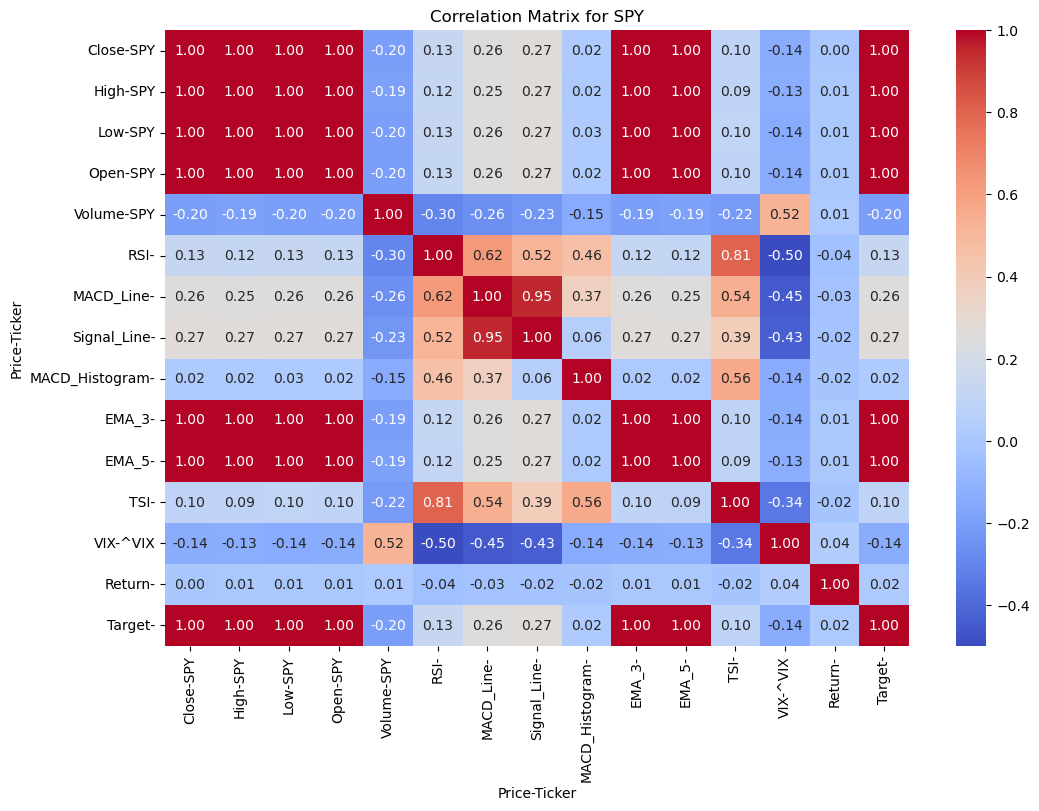

=== Correlation Analysis for QQQ ===


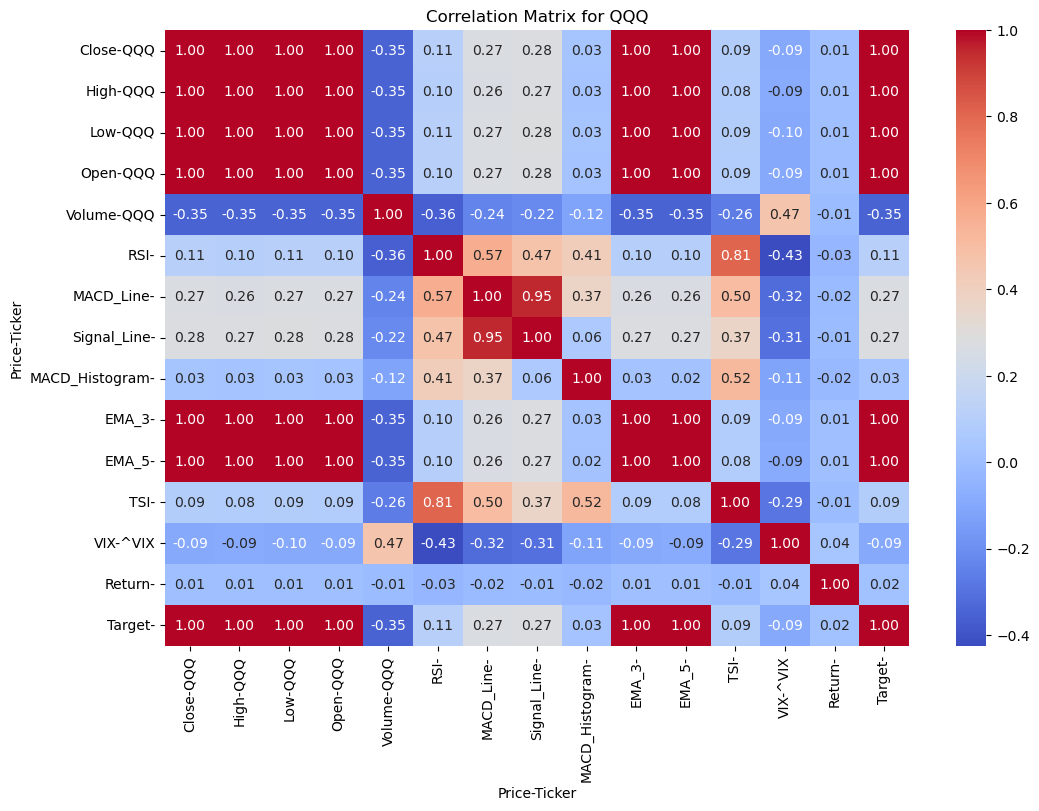

=== Correlation Analysis for DIA ===


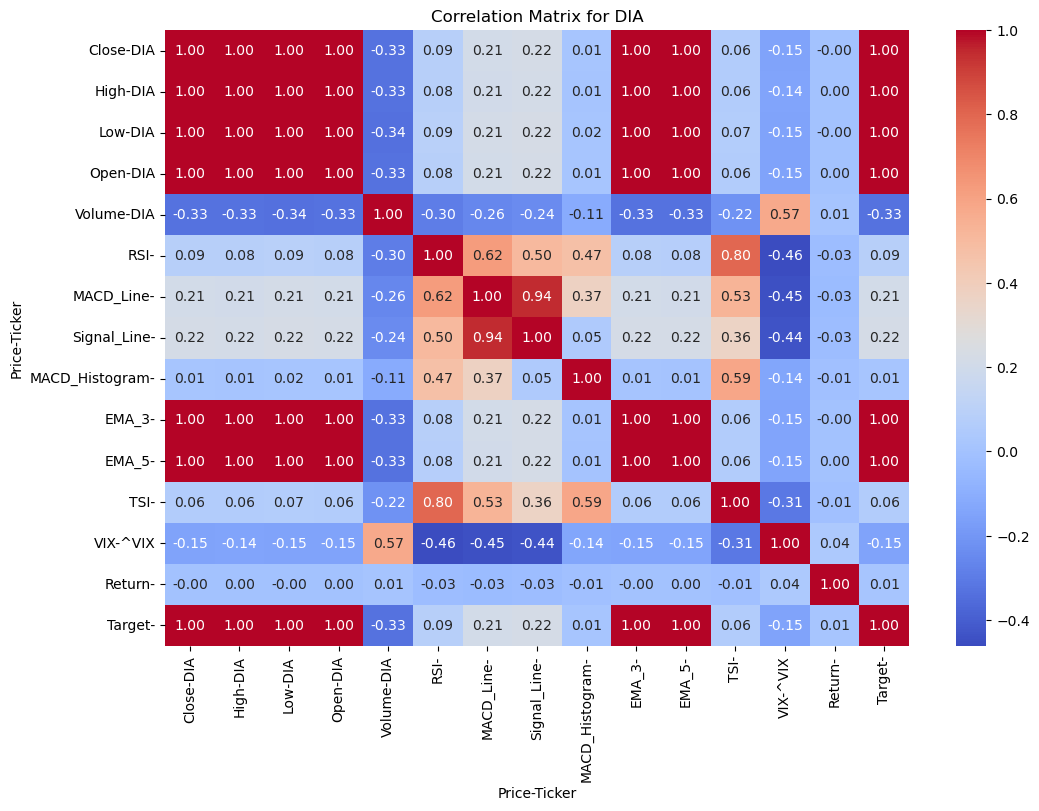

In [34]:
# Function to compute and plot correlation matrix
def plot_correlation_matrix(df, ticker):
    df = df.copy()
    
    # Drop rows with NaN values (especially from indicators and shift)
    df.dropna(inplace=True)
    
    # Add the target column (next day's closing price)
    df['Target'] = df['Close'].shift(-1)

    # Re-drop last row (now has NaN in Target)
    df.dropna(inplace=True)

    # Compute correlation matrix
    correlation = df.corr()

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f'Correlation Matrix for {ticker}')
    plt.show()

# Apply to all 3 tickers
for ticker in ['SPY', 'QQQ', 'DIA']:
    print(f"=== Correlation Analysis for {ticker} ===")
    plot_correlation_matrix(data[ticker], ticker)

# 5. Flatten MultiIndex Columns for Training

In [35]:
# ----------------------------
# A) FLATTEN MultiIndex columns
# ----------------------------
df_flat = data['SPY']  # or whatever ticker
df_flat.columns = df_flat.columns.get_level_values(0)
# Now df_flat.columns might look like:
#   ['Close','High','Low','Open','Volume','RSI','MACD_Line','Signal_Line','MACD_Histogram',
#    'EMA_3','EMA_5','TSI','VIX','Return']
#
# Replace data['SPY'] with this flattened version:
data['SPY'] = df_flat.copy()

# Repeat for QQQ and DIA:
for ticker in ['QQQ','DIA']:
    df_flat = data[ticker]
    df_flat.columns = df_flat.columns.get_level_values(0)
    data[ticker] = df_flat.copy()


# 6. Train XGBoost Model



=== TICKER: SPY ===
Total days: 6,356   |   Initial train size: 5,084
Trained through 2020-05-05, forecasted 2020-05-06, AE=1.68, SE=2.82, APE=0.64%, R²_so_far=nan
Trained through 2020-09-25, forecasted 2020-09-28, AE=1.71, SE=2.92, APE=0.55%, R²_so_far=0.9593
Trained through 2021-02-19, forecasted 2021-02-22, AE=3.62, SE=13.10, APE=0.99%, R²_so_far=0.9749
Trained through 2021-07-14, forecasted 2021-07-15, AE=8.87, SE=78.70, APE=2.15%, R²_so_far=0.9859
Trained through 2021-12-03, forecasted 2021-12-06, AE=3.73, SE=13.88, APE=0.85%, R²_so_far=0.9906
Trained through 2022-04-28, forecasted 2022-04-29, AE=6.70, SE=44.91, APE=1.70%, R²_so_far=0.9922
Trained through 2022-09-21, forecasted 2022-09-22, AE=0.65, SE=0.42, APE=0.18%, R²_so_far=0.9917
Trained through 2023-02-14, forecasted 2023-02-15, AE=1.80, SE=3.24, APE=0.45%, R²_so_far=0.9915
Trained through 2023-07-11, forecasted 2023-07-12, AE=0.81, SE=0.66, APE=0.19%, R²_so_far=0.9919
Trained through 2023-11-30, forecasted 2023-12-01, AE=

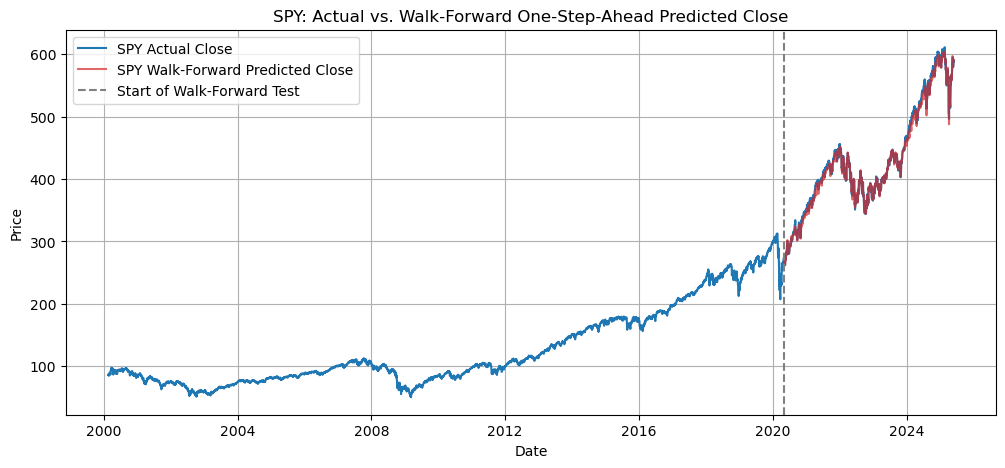

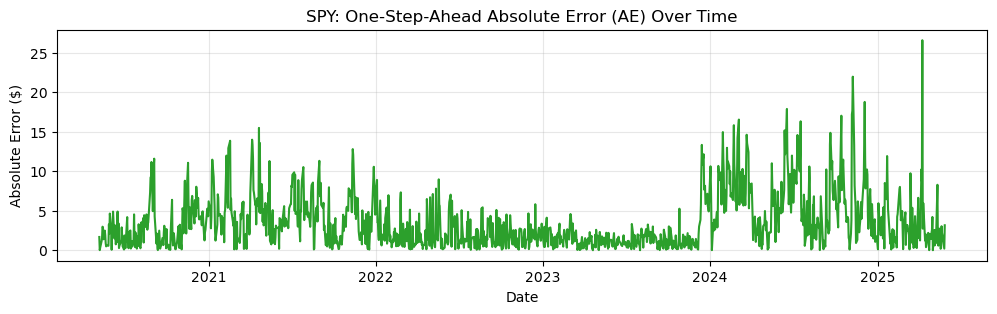

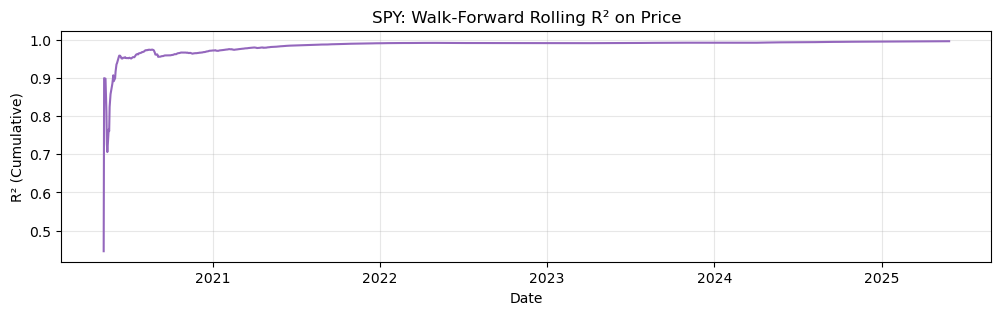



=== TICKER: QQQ ===
Total days: 6,356   |   Initial train size: 5,084
Trained through 2020-05-05, forecasted 2020-05-06, AE=0.13, SE=0.02, APE=0.06%, R²_so_far=nan
Trained through 2020-09-25, forecasted 2020-09-28, AE=1.42, SE=2.02, APE=0.53%, R²_so_far=0.8676
Trained through 2021-02-19, forecasted 2021-02-22, AE=0.30, SE=0.09, APE=0.09%, R²_so_far=0.9537
Trained through 2021-07-14, forecasted 2021-07-15, AE=11.99, SE=143.82, APE=3.41%, R²_so_far=0.9731
Trained through 2021-12-03, forecasted 2021-12-06, AE=9.79, SE=95.90, APE=2.59%, R²_so_far=0.9840
Trained through 2022-04-28, forecasted 2022-04-29, AE=2.72, SE=7.38, APE=0.89%, R²_so_far=0.9858
Trained through 2022-09-21, forecasted 2022-09-22, AE=5.77, SE=33.24, APE=2.09%, R²_so_far=0.9859
Trained through 2023-02-14, forecasted 2023-02-15, AE=2.92, SE=8.55, APE=0.96%, R²_so_far=0.9871
Trained through 2023-07-11, forecasted 2023-07-12, AE=0.60, SE=0.37, APE=0.16%, R²_so_far=0.9877
Trained through 2023-11-30, forecasted 2023-12-01, AE

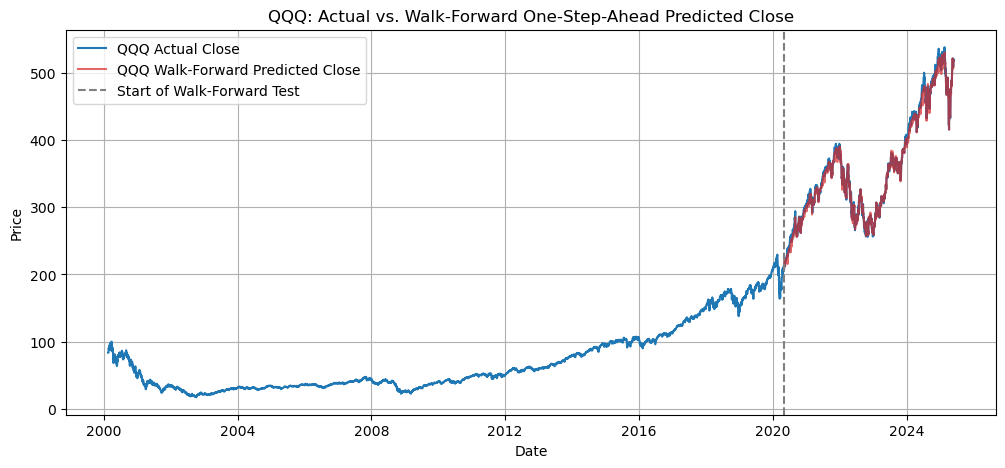

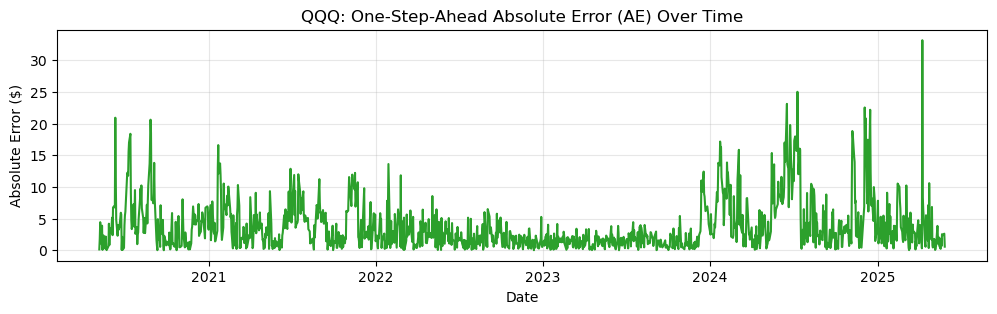

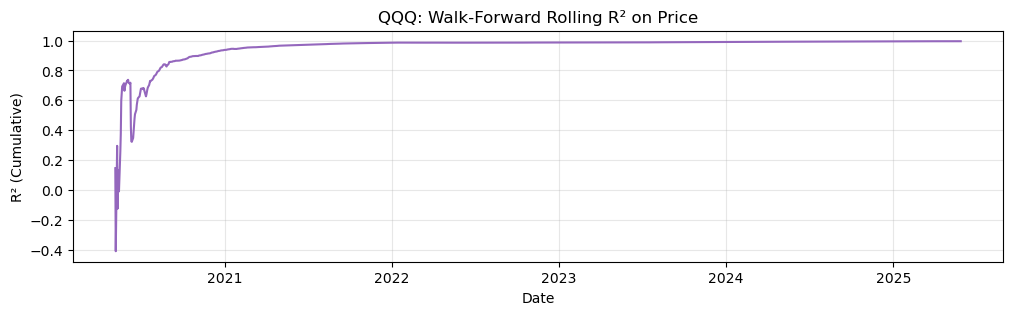



=== TICKER: DIA ===
Total days: 6,356   |   Initial train size: 5,084
Trained through 2020-05-05, forecasted 2020-05-06, AE=0.40, SE=0.16, APE=0.19%, R²_so_far=nan
Trained through 2020-09-25, forecasted 2020-09-28, AE=0.62, SE=0.39, APE=0.24%, R²_so_far=0.9828
Trained through 2021-02-19, forecasted 2021-02-22, AE=3.56, SE=12.67, APE=1.21%, R²_so_far=0.9827
Trained through 2021-07-14, forecasted 2021-07-15, AE=2.97, SE=8.84, APE=0.91%, R²_so_far=0.9888
Trained through 2021-12-03, forecasted 2021-12-06, AE=3.84, SE=14.76, APE=1.16%, R²_so_far=0.9920
Trained through 2022-04-28, forecasted 2022-04-29, AE=5.53, SE=30.56, APE=1.77%, R²_so_far=0.9930
Trained through 2022-09-21, forecasted 2022-09-22, AE=1.58, SE=2.50, APE=0.55%, R²_so_far=0.9927
Trained through 2023-02-14, forecasted 2023-02-15, AE=0.39, SE=0.15, APE=0.12%, R²_so_far=0.9929
Trained through 2023-07-11, forecasted 2023-07-12, AE=0.59, SE=0.35, APE=0.18%, R²_so_far=0.9933
Trained through 2023-11-30, forecasted 2023-12-01, AE=9

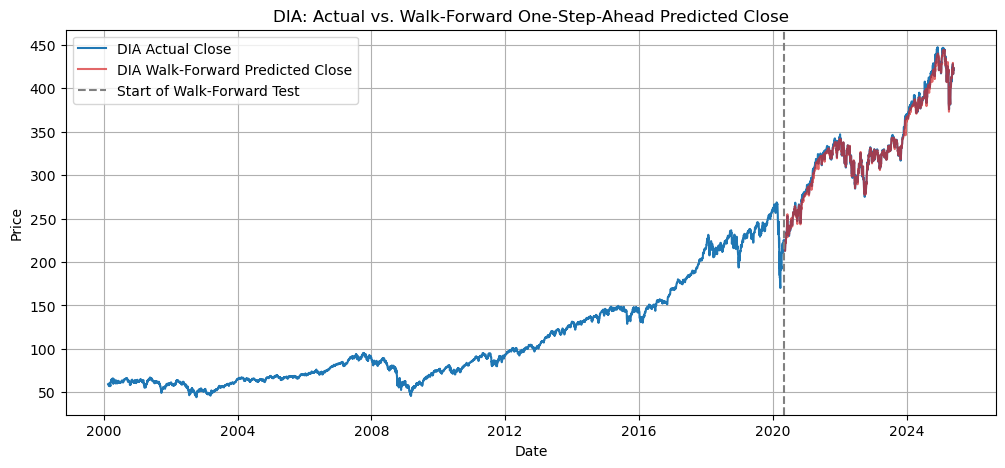

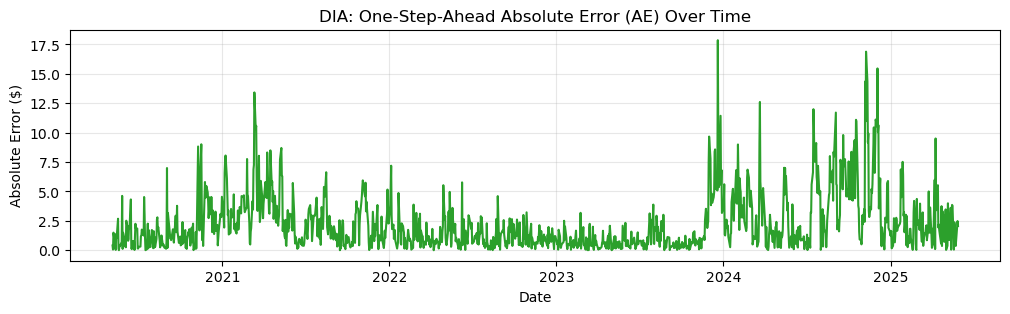

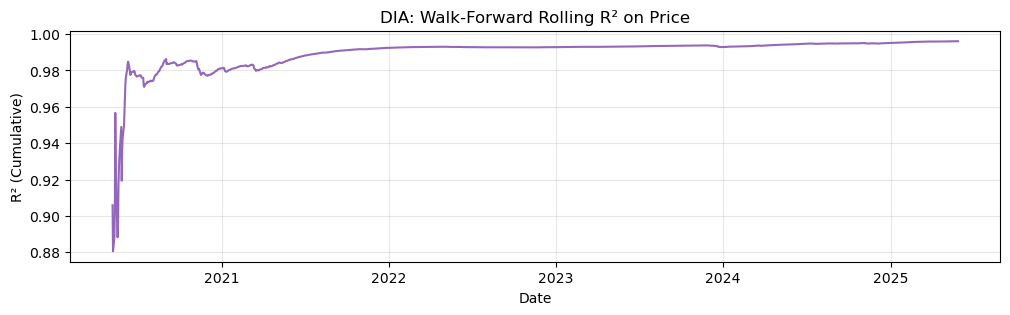

In [36]:
# List of tickers to process
tickers = ['SPY', 'QQQ', 'DIA']

# Features to use at each time t
features = [
    'Close','Open','High','Low','Volume',
    'EMA_3','EMA_5',
    'RSI','MACD_Histogram','TSI','VIX'
]

for ticker in tickers:
    print(f"\n\n=== TICKER: {ticker} ===")

    # ────────────────────────────────────────────────────────
    # (A) PREPARE THE DATAFRAME FOR NEXT‐DAY “CLOSE” FORECASTING
    # ────────────────────────────────────────────────────────

    # 1) Grab the flattened DataFrame for this ticker
    df = data[ticker].copy()   # assume already flattened

    # 2) Create the next‐day‐close target: TargetClose[t] = Close[t+1]
    df['TargetClose'] = df['Close'].shift(-1)

    # 3) Drop rows where TargetClose is NaN (i.e. the final row)
    df = df.dropna(subset=['TargetClose']).copy()

    # 4) Extract arrays for walk‐forward
    X_all   = df[features].values        # shape = (N, n_features)
    y_all   = df['TargetClose'].values    # shape = (N,)
    dates   = df.index                    # DatetimeIndex length = N

    # 5) Compute initial‐train size (80% of rows)
    N = len(df)
    initial_train_size = int(0.8 * N)
    print(f"Total days: {N:,}   |   Initial train size: {initial_train_size:,}")

    # 6) Prepare placeholders for forecasts and actual closes
    pred_close_walk   = pd.Series(data=np.nan, index=dates)   # predicted Close[t] (forecast of t+1)
    actual_close_walk = df['Close'].copy()                    # actual Close[t]

    #  We will store one‐step‐ahead errors (AE, SE, APE, R²) in lists
    ae_list   = []   # absolute error = |y_true - y_pred|
    se_list   = []   # squared error  = (y_true - y_pred)^2
    ape_list  = []   # absolute percentage error = |y_true - y_pred| / |y_true|
    r2_list   = []   # rolling R² (cumulative)
    date_list = []

    # ────────────────────────────────────────────────────────
    # (B) WALK‐FORWARD LOOP (EXPANDING WINDOW)
    # ────────────────────────────────────────────────────────

    for day_idx in range(initial_train_size, N):
        # (B.1) Extract train‐block [0 … day_idx-1] and test‐point = day_idx
        train_idx = np.arange(day_idx)       # [0, 1, …, day_idx-1]
        test_idx  = day_idx                  # single integer

        X_train = X_all[train_idx, :]        # features rows 0…day_idx-1
        y_train = y_all[train_idx]           # targets rows 0…day_idx-1

        X_test  = X_all[test_idx:test_idx+1, :]
        # shape = (1, n_features): features of row “day_idx” (to predict Close at day_idx+1)

        # (B.2) Scale features (fit on train, transform test)
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        # (B.3) Train XGBoost to predict TargetClose = Close(t+1)
        model = XGBRegressor(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=5,
            gamma=1,
            objective='reg:squarederror',
            random_state=42,
            verbosity=0
        )
        model.fit(X_train_scaled, y_train)

        # (B.4) One‐step‐ahead forecast: predict Close for next day
        y_pred_next_close = model.predict(X_test_scaled)[0]
        pred_close_walk.iloc[day_idx] = y_pred_next_close

        # (B.5) Record errors for this “held‐out day_idx” 
        actual_c = actual_close_walk.iloc[day_idx]
        ae_day   = abs(actual_c - y_pred_next_close)                   # absolute error
        se_day   = (actual_c - y_pred_next_close) ** 2                  # squared error
        ape_day  = ae_day / abs(actual_c) * 100 if actual_c != 0 else np.nan

        ae_list.append(ae_day)
        se_list.append(se_day)
        ape_list.append(ape_day)
        date_list.append(dates[day_idx])

        # (B.6) Compute rolling R² over all forecasts so far
        if len(ae_list) > 1:
            y_true_so_far = actual_close_walk.loc[date_list]
            y_pred_so_far = pred_close_walk.loc[date_list]
            r2_so_far     = r2_score(y_true_so_far, y_pred_so_far)
        else:
            r2_so_far = np.nan
        r2_list.append(r2_so_far)

        # Print progress every 100 walk-forward days
        if (day_idx - initial_train_size) % 100 == 0:
            print(
                f"Trained through {dates[day_idx-1].date()}, "
                f"forecasted {dates[day_idx].date()}, "
                f"AE={ae_day:.2f}, SE={se_day:.2f}, APE={ape_day:.2f}%, "
                f"R²_so_far={r2_so_far:.4f}"
            )

    # ────────────────────────────────────────────────────────
    # (C) AGGREGATE & PRINT SUMMARY STATISTICS FOR THIS TICKER
    # ────────────────────────────────────────────────────────

    # Build a small DataFrame of the walk‐forward errors
    errors_df = pd.DataFrame({
        'Date'    : date_list,
        'AE'      : ae_list,
        'SE'      : se_list,
        'APE'     : ape_list,
        'R2_so_far': r2_list
    }).set_index('Date')

    # Compute overall metrics:
    mean_mae   = np.mean(errors_df['AE'])
    mean_mse   = np.mean(errors_df['SE'])
    mean_rmse  = np.sqrt(mean_mse)
    mean_mape  = np.mean(errors_df['APE'])
    final_r2   = errors_df['R2_so_far'].iloc[-1]  # last cumulative R²

    print(f"\n>>> {ticker} WALK‐FORWARD SUMMARY <<<")
    print(f"One‐step‐ahead MAE:    {mean_mae:.4f}")
    print(f"One‐step‐ahead MSE:    {mean_mse:.4f}")
    print(f"One‐step‐ahead RMSE:   {mean_rmse:.4f}")
    print(f"One‐step‐ahead MAPE:   {mean_mape:.2f}%")
    print(f"One‐step‐ahead R²:     {final_r2:.4f}\n")

    # 1) Plot actual vs. predicted close (walk‐forward)
    plt.figure(figsize=(12,5))
    plt.plot(
        actual_close_walk.index,
        actual_close_walk.values,
        label=f"{ticker} Actual Close",
        color='tab:blue'
    )
    plt.plot(
        pred_close_walk.index,
        pred_close_walk.values,
        label=f"{ticker} Walk‐Forward Predicted Close",
        color='tab:red',
        alpha=0.7
    )
    plt.axvline(
        x=dates[initial_train_size],
        color='gray',
        linestyle='--',
        label="Start of Walk‐Forward Test"
    )
    plt.title(f"{ticker}: Actual vs. Walk‐Forward One‐Step‐Ahead Predicted Close")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2) Plot day‐by‐day AE (MAE) over time
    plt.figure(figsize=(12,3))
    plt.plot(errors_df.index, errors_df['AE'], color='tab:green')
    plt.title(f"{ticker}: One‐Step‐Ahead Absolute Error (AE) Over Time")
    plt.xlabel("Date")
    plt.ylabel("Absolute Error ($)")
    plt.grid(alpha=0.3)
    plt.show()

    # 3) Plot rolling R² over time
    plt.figure(figsize=(12,3))
    plt.plot(errors_df.index, errors_df['R2_so_far'], color='tab:purple')
    plt.title(f"{ticker}: Walk‐Forward Rolling R² on Price")
    plt.xlabel("Date")
    plt.ylabel("R² (Cumulative)")
    plt.grid(alpha=0.3)
    plt.show()

# 7. LSTM Model

In [ ]:
from tensorflow.keras.layers import LSTM

# Define sequence length for LSTM
timesteps = 30

def create_sequences(X, y, timesteps):
    """
    Create 3D sequences for LSTM input and corresponding targets.
    Returns: X_seq (n_samples, timesteps, n_features), y_seq (n_samples,)
    """
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Define LSTM model architecture once, outside the loop
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(timesteps, len(features))),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Output: single scalar for next-day Close
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Store initial weights to reset model each iteration
initial_weights = model.get_weights()

for ticker in tickers[:3]:  # Exclude ^VIX since it's a feature, not a target
    print(f"\n\n=== TICKER: {ticker} ===")

    # ──────────────────────────────────────────────────────────────
    # (A) PREPARE THE DATAFRAME FOR NEXT-DAY ‘CLOSE’ FORECASTING
    # ──────────────────────────────────────────────────────────────

    # 1) Grab the flattened DataFrame for this ticker
    df = data[ticker].copy()

    # 2) Create the next-day-close target: TargetClose[t] = Close[t+1]
    df['TargetClose'] = df['Close'].shift(-1)

    # 3) Drop rows where TargetClose is NaN (i.e., the final row)
    df = df.dropna(subset=['TargetClose']).copy()

    # 4) Extract arrays for walk-forward
    X_all = df[features].values  # shape = (N, n_features)
    y_all = df['TargetClose'].values  # shape = (N,)
    dates = df.index  # DatetimeIndex length = N

    # 5) Compute initial-train size (80% of rows)
    N = len(df)
    initial_train_size = int(0.8 * N)
    print(f"Total days: {N:,}   |   Initial train size: {initial_train_size:,}")

    # 6) Prepare placeholders for forecasts and actual closes
    pred_close_walk = pd.Series(data=np.nan, index=dates)  # predicted Close[t] (forecast of t+1)
    actual_close_walk = df['Close'].copy()  # actual Close[t]

    # Lists to store one-step-ahead errors
    ae_list = []  # absolute error = |y_true - y_pred|
    se_list = []  # squared error = (y_true - y_pred)^2
    ape_list = []  # absolute percentage error = |y_true - y_pred| / |y_true|
    r2_list = []  # rolling R² (cumulative)
    date_list = []

    # ──────────────────────────────────────────────────────────────
    # (B) WALK-FORWARD LOOP (EXPANDING WINDOW)
    # ──────────────────────────────────────────────────────────────

    for day_idx in range(initial_train_size, N):
        # (B.1) Extract train-block [0 … day_idx-1] and test-point = day_idx
        train_idx = np.arange(timesteps, day_idx)  # Start from timesteps to allow sequence creation
        test_idx = day_idx  # single integer

        X_train = X_all[:day_idx, :]  # features rows 0…day_idx-1
        y_train = y_all[:day_idx]  # targets rows 0…day_idx-1
        X_test = X_all[day_idx-timesteps:day_idx+1, :]  # sequence for prediction

        # (B.2) Scale features and target
        feature_scaler = MinMaxScaler()
        target_scaler = MinMaxScaler()
        
        # Fit scalers on training data only
        X_train_scaled = feature_scaler.fit_transform(X_train)
        y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
        
        # Transform test sequence
        X_test_scaled = feature_scaler.transform(X_test)

        # (B.3) Create sequences for LSTM
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
        X_test_seq = X_test_scaled[-timesteps:].reshape(1, timesteps, len(features))

        # (B.4) Reset model weights and train LSTM model
        model.set_weights(initial_weights)  # Reset to initial weights
        model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=0)

        # (B.5) One-step-ahead forecast: predict Close for next day
        y_pred_scaled = model.predict(X_test_seq, verbose=0)[0, 0]
        y_pred_next_close = target_scaler.inverse_transform([[y_pred_scaled]])[0, 0]
        pred_close_walk.iloc[day_idx] = y_pred_next_close

        # (B.6) Record errors for this ‘held-out day_idx’
        actual_c = actual_close_walk.iloc[day_idx]
        ae_day = abs(actual_c - y_pred_next_close)  # absolute error
        se_day = (actual_c - y_pred_next_close) ** 2  # squared error
        ape_day = ae_day / abs(actual_c) * 100 if actual_c != 0 else np.nan

        ae_list.append(ae_day)
        se_list.append(se_day)
        ape_list.append(ape_day)
        date_list.append(dates[day_idx])

        # (B.7) Compute rolling R² over all forecasts so far
        if len(ae_list) > 1:
            y_true_so_far = actual_close_walk.loc[date_list]
            y_pred_so_far = pred_close_walk.loc[date_list]
            r2_so_far = r2_score(y_true_so_far, y_pred_so_far)
        else:
            r2_so_far = np.nan
        r2_list.append(r2_so_far)

        # Print progress every 100 walk-forward days
        if (day_idx - initial_train_size) % 100 == 0:
            print(
                f"Trained through {dates[day_idx-1].date()}, "
                f"forecasted {dates[day_idx].date()}, "
                f"AE={ae_day:.2f}, SE={se_day:.2f}, APE={ape_day:.2f}%, "
                f"R²_so_far={r2_so_far:.4f}"
            )

    # ──────────────────────────────────────────────────────────────
    # (C) AGGREGATE & PRINT SUMMARY STATISTICS FOR THIS TICKER
    # ──────────────────────────────────────────────────────────────

    # Build a DataFrame of the walk-forward errors
    errors_df = pd.DataFrame({
        'Date': date_list,
        'AE': ae_list,
        'SE': se_list,
        'APE': ape_list,
        'R2_so_far': r2_list
    }).set_index('Date')

    # Compute overall metrics
    mean_mae = np.mean(errors_df['AE'])
    mean_mse = np.mean(errors_df['SE'])
    mean_rmse = np.sqrt(mean_mse)
    mean_mape = np.mean(errors_df['APE'])
    final_r2 = errors_df['R2_so_far'].iloc[-1]  # last cumulative R²

    print(f"\n>>> {ticker} WALK-FORWARD SUMMARY <<<")
    print(f"One-step-ahead MAE:    {mean_mae:.4f}")
    print(f"One-step-ahead MSE:    {mean_mse:.4f}")
    print(f"One-step-ahead RMSE:   {mean_rmse:.4f}")
    print(f"One-step-ahead MAPE:   {mean_mape:.2f}%")
    print(f"One-step-ahead R²:     {final_r2:.4f}\n")

    # 1) Plot actual vs. predicted close (walk-forward)
    plt.figure(figsize=(12, 5))
    plt.plot(
        actual_close_walk.index,
        actual_close_walk.values,
        label=f"{ticker} Actual Close",
        color='tab:blue'
    )
    plt.plot(
        pred_close_walk.index,
        pred_close_walk.values,
        label=f"{ticker} Walk-Forward Predicted Close",
        color='tab:red',
        alpha=0.7
    )
    plt.axvline(
        x=dates[initial_train_size],
        color='gray',
        linestyle='--',
        label="Start of Walk-Forward Test"
    )
    plt.title(f"{ticker}: Actual vs. Walk-Forward One-Step-Ahead Predicted Close")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2) Plot day-by-day AE (MAE) over time
    plt.figure(figsize=(12, 3))
    plt.plot(errors_df.index, errors_df['AE'], color='tab:green')
    plt.title(f"{ticker}: One-Step-Ahead Absolute Error (AE) Over Time")
    plt.xlabel("Date")
    plt.ylabel("Absolute Error ($)")
    plt.grid(alpha=0.3)
    plt.show()

    # 3) Plot rolling R² over time
    plt.figure(figsize=(12, 3))
    plt.plot(errors_df.index, errors_df['R2_so_far'], color='tab:purple')
    plt.title(f"{ticker}: Walk-Forward Rolling R² on Price")
    plt.xlabel("Date")
    plt.ylabel("R² (Cumulative)")
    plt.grid(alpha=0.3)
    plt.show()



=== TICKER: SPY ===
Total days: 6,356   |   Initial train size: 5,084
Trained through 2020-05-05, forecasted 2020-05-06, AE=16.84, SE=283.64, APE=6.37%, R²_so_far=nan
Trained through 2020-09-25, forecasted 2020-09-28, AE=50.34, SE=2533.95, APE=16.07%, R²_so_far=-1.8863
Trained through 2021-02-19, forecasted 2021-02-22, AE=42.37, SE=1795.46, APE=11.63%, R²_so_far=-0.3646
Trained through 2021-07-14, forecasted 2021-07-15, AE=50.18, SE=2518.22, APE=12.18%, R²_so_far=0.2421
Trained through 2021-12-03, forecasted 2021-12-06, AE=54.15, SE=2932.75, APE=12.41%, R²_so_far=0.4354
Trained through 2022-04-28, forecasted 2022-04-29, AE=12.56, SE=157.74, APE=3.18%, R²_so_far=0.4528


# 8. GRU Model

In [ ]:
# 8. GRU Model

# Define sequence length for GRU
timesteps = 30

def create_sequences(X, y, timesteps):
    """
    Create 3D sequences for GRU input and corresponding targets.
    Returns: X_seq (n_samples, timesteps, n_features), y_seq (n_samples,)
    """
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Define GRU model architecture once, outside the loop
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(timesteps, len(features))),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Output: single scalar for next-day Close
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Store initial weights to reset model each iteration
initial_weights = model.get_weights()

for ticker in tickers[:3]:  # Exclude ^VIX since it's a feature, not a target
    print(f"\n\n=== TICKER: {ticker} ===")

    # ────────────────────────────────────────────────────────
    # (A) PREPARE THE DATAFRAME FOR NEXT‐DAY “CLOSE” FORECASTING
    # ────────────────────────────────────────────────────────

    # 1) Grab the flattened DataFrame for this ticker
    df = data[ticker].copy()

    # 2) Create the next‐day‐close target: TargetClose[t] = Close[t+1]
    df['TargetClose'] = df['Close'].shift(-1)

    # 3) Drop rows where TargetClose is NaN (i.e., the final row)
    df = df.dropna(subset=['TargetClose']).copy()

    # 4) Extract arrays for walk‐forward
    X_all = df[features].values  # shape = (N, n_features)
    y_all = df['TargetClose'].values  # shape = (N,)
    dates = df.index  # DatetimeIndex length = N

    # 5) Compute initial‐train size (80% of rows)
    N = len(df)
    initial_train_size = int(0.8 * N)
    print(f"Total days: {N:,}   |   Initial train size: {initial_train_size:,}")

    # 6) Prepare placeholders for forecasts and actual closes
    pred_close_walk = pd.Series(data=np.nan, index=dates)  # predicted Close[t] (forecast of t+1)
    actual_close_walk = df['Close'].copy()  # actual Close[t]

    # Lists to store one‐step‐ahead errors
    ae_list = []  # absolute error = |y_true - y_pred|
    se_list = []  # squared error = (y_true - y_pred)^2
    ape_list = []  # absolute percentage error = |y_true - y_pred| / |y_true|
    r2_list = []  # rolling R² (cumulative)
    date_list = []

    # ────────────────────────────────────────────────────────
    # (B) WALK‐FORWARD LOOP (EXPANDING WINDOW)
    # ────────────────────────────────────────────────────────

    for day_idx in range(initial_train_size, N):
        # (B.1) Extract train‐block [0 … day_idx-1] and test‐point = day_idx
        train_idx = np.arange(timesteps, day_idx)  # Start from timesteps to allow sequence creation
        test_idx = day_idx  # single integer

        X_train = X_all[:day_idx, :]  # features rows 0…day_idx-1
        y_train = y_all[:day_idx]  # targets rows 0…day_idx-1
        X_test = X_all[day_idx-timesteps:day_idx+1, :]  # sequence for prediction

        # (B.2) Scale features and target
        feature_scaler = MinMaxScaler()
        target_scaler = MinMaxScaler()
        
        # Fit scalers on training data only
        X_train_scaled = feature_scaler.fit_transform(X_train)
        y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
        
        # Transform test sequence
        X_test_scaled = feature_scaler.transform(X_test)

        # (B.3) Create sequences for GRU
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
        X_test_seq = X_test_scaled[-timesteps:].reshape(1, timesteps, len(features))

        # (B.4) Reset model weights and train GRU model
        model.set_weights(initial_weights)  # Reset to initial weights
        model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=0)

        # (B.5) One‐step‐ahead forecast: predict Close for next day
        y_pred_scaled = model.predict(X_test_seq, verbose=0, reduce_retracing=True)[0, 0]
        y_pred_next_close = target_scaler.inverse_transform([[y_pred_scaled]])[0, 0]
        pred_close_walk.iloc[day_idx] = y_pred_next_close

        # (B.6) Record errors for this “held‐out day_idx”
        actual_c = actual_close_walk.iloc[day_idx]
        ae_day = abs(actual_c - y_pred_next_close)  # absolute error
        se_day = (actual_c - y_pred_next_close) ** 2  # squared error
        ape_day = ae_day / abs(actual_c) * 100 if actual_c != 0 else np.nan

        ae_list.append(ae_day)
        se_list.append(se_day)
        ape_list.append(ape_day)
        date_list.append(dates[day_idx])

        # (B.7) Compute rolling R² over all forecasts so far
        if len(ae_list) > 1:
            y_true_so_far = actual_close_walk.loc[date_list]
            y_pred_so_far = pred_close_walk.loc[date_list]
            r2_so_far = r2_score(y_true_so_far, y_pred_so_far)
        else:
            r2_so_far = np.nan
        r2_list.append(r2_so_far)

        # Print progress every 100 walk-forward days
        if (day_idx - initial_train_size) % 100 == 0:
            print(
                f"Trained through {dates[day_idx-1].date()}, "
                f"forecasted {dates[day_idx].date()}, "
                f"AE={ae_day:.2f}, SE={se_day:.2f}, APE={ape_day:.2f}%, "
                f"R²_so_far={r2_so_far:.4f}"
            )

    # ────────────────────────────────────────────────────────
    # (C) AGGREGATE & PRINT SUMMARY STATISTICS FOR THIS TICKER
    # ────────────────────────────────────────────────────────

    # Build a DataFrame of the walk‐forward errors
    errors_df = pd.DataFrame({
        'Date': date_list,
        'AE': ae_list,
        'SE': se_list,
        'APE': ape_list,
        'R2_so_far': r2_list
    }).set_index('Date')

    # Compute overall metrics
    mean_mae = np.mean(errors_df['AE'])
    mean_mse = np.mean(errors_df['SE'])
    mean_rmse = np.sqrt(mean_mse)
    mean_mape = np.mean(errors_df['APE'])
    final_r2 = errors_df['R2_so_far'].iloc[-1]  # last cumulative R²

    print(f"\n>>> {ticker} WALK‐FORWARD SUMMARY <<<")
    print(f"One‐step‐ahead MAE:    {mean_mae:.4f}")
    print(f"One‐step‐ahead MSE:    {mean_mse:.4f}")
    print(f"One‐step‐ahead RMSE:   {mean_rmse:.4f}")
    print(f"One‐step‐ahead MAPE:   {mean_mape:.2f}%")
    print(f"One‐step‐ahead R²:     {final_r2:.4f}\n")

    # 1) Plot actual vs. predicted close (walk‐forward)
    plt.figure(figsize=(12, 5))
    plt.plot(
        actual_close_walk.index,
        actual_close_walk.values,
        label=f"{ticker} Actual Close",
        color='tab:blue'
    )
    plt.plot(
        pred_close_walk.index,
        pred_close_walk.values,
        label=f"{ticker} Walk‐Forward Predicted Close",
        color='tab:red',
        alpha=0.7
    )
    plt.axvline(
        x=dates[initial_train_size],
        color='gray',
        linestyle='--',
        label="Start of Walk‐Forward Test"
    )
    plt.title(f"{ticker}: Actual vs. Walk‐Forward One‐Step‐Ahead Predicted Close")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2) Plot day‐by‐day AE (MAE) over time
    plt.figure(figsize=(12, 3))
    plt.plot(errors_df.index, errors_df['AE'], color='tab:green')
    plt.title(f"{ticker}: One‐Step‐Ahead Absolute Error (AE) Over Time")
    plt.xlabel("Date")
    plt.ylabel("Absolute Error ($)")
    plt.grid(alpha=0.3)
    plt.show()

    # 3) Plot rolling R² over time
    plt.figure(figsize=(12, 3))
    plt.plot(errors_df.index, errors_df['R2_so_far'], color='tab:purple')
    plt.title(f"{ticker}: Walk‐Forward Rolling R² on Price")
    plt.xlabel("Date")
    plt.ylabel("R² (Cumulative)")
    plt.grid(alpha=0.3)
    plt.show()